*CNN with sequential GloVe embeddings*

This notebook performs classification on the Twitter Sentiment140 dataset with ~1.6 milllions tweets. We use Stanford's pretrained [GloVe embedding ](https://nlp.stanford.edu/projects/glove/) to format our data and classify with a Convolutional Neural Network (CNN)

In [4]:
%load_ext autoreload
%autoreload 2
from data_preprocessing import *

[Errno 2] No such file or directory: 'GloVe_Sentiment_Analysis_MLP_CNN_TwitterSentiment140-master/'
/content/GloVe_Sentiment_Analysis_MLP_CNN_TwitterSentiment140-master


In [0]:
#use glove embedding for embedding vocabulary matrix embedding but 
#CountVectorizer and tfidf for tweets
word2vectors, word2id = load_GloVe_twitter_emb() 
# load the twitter dataset and splits in train/val/test
train, val, test = load_twitter_datasets(n_train=25000, n_val=8000)

In [9]:
tweets = train.tweet.apply(normalize_text).values
# original tweets
train.tweet.values[:25]

array(['Camera shopping today ',
       'Home now. No work again at the ward untill tuesday!  But lots of drawing to be done! but now some COD4!!',
       'OMG HANNAH MONTANA MOVIE WAS AWESOME!!!!! AGH LOVED IT SO MUCH! the guy was hot ;) hahaha @SabrinaBryan no dont leave me hanging ',
       '@LeoWolfe I dont watch the live feeds though  and ok ',
       'my tummy hurts ', 'My comp crashes again ',
       'won a LED 5W AA powered flashlight, because my existing normal AA powered flashlight makes me ',
       'Doing work!!! Homework that is  1 wk left before FINALS its crunch time...',
       'http://twitpic.com/6tqbf - P!nk rocking it in Sydney  Me the amateur photographer!',
       '@DonaldUSAFan We do not choose how we are packaged- our DNA &amp; Angels ;) do-but WE can choose our behavior, our actions &amp; treatment of ppl ',
       'so tired...taking a nap ',
       "@RachelHawley If its a 15, they won't let me do it ",
       'Tonight IÂ´ll be watching Rock am Ring  Yesterday w

In [10]:
tweets[:10]

array(['camera shopping today',
       'home now no work again at the ward untill tuesday but lots of drawing to be done but now some cod',
       'omg hannah montana movie was awesome agh loved it so much the guy was hot hahaha sabrinabryan no dont leave me hanging',
       'leowolfe i dont watch the live feeds though and ok',
       'my tummy hurts', 'my comp crashes again',
       'won a led w aa powered flashlight because my existing normal aa powered flashlight makes me',
       'doing work homework that is wk left before finals its crunch time',
       'http twitpic com tqbf p nk rocking it in sydney me the amateur photographer',
       'donaldusafan we do not choose how we are packaged our dna amp angels do but we can choose our behavior our actions amp treatment of ppl'],
      dtype=object)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
def vectorize_words(dataSetObj):
    tweets = dataSetObj.tweet.apply(normalize_text).values
    polarities = dataSetObj.polarity
    # extract features
    '''train_tweets, test_tweets = train_test_split(
        tweets,
        polarities,
        train_size
        )
        '''

    x_train = CountVectorizer(  # max_df=.9,
                analyzer='word',
                lowercase=False,
            )

    x_train = x_train.fit_transform(tweets)

 
    return x_train, polarities

In [22]:
from useful_components import TwitterDataset 
df = TwitterDataSet()
Xtrain, Ytrain, Xval, Yval df.get_test_train_split()
Xtest, Ytest = processAllTweets2vec(test) #returns feature_count_tfidf and polarities
Xtrain.shape, Ytrain.shape

((25000, 200), (25000, 1))

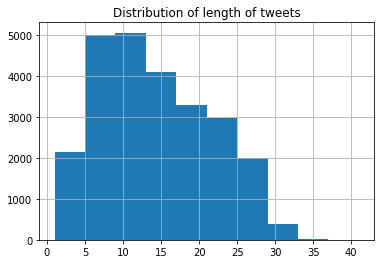

In [23]:
# look into distribution of length of tweets to determine optimal padding
import matplotlib.pyplot as plt
train.tweet.apply(normalize_text).apply(lambda x: len(x.split(' '))).hist()
plt.title('Distribution of length of tweets')
plt.show()

Create embedding matrix

In [24]:
#Create embedding matrix for CNN
vocab = extractVocabulary(train)
restrictedWord2id, embMatrix = vocabEmbeddings(vocab, word2vectors)

100%|██████████| 25000/25000 [00:08<00:00, 2854.87it/s]


In [25]:
embMatrix.shape

(13158, 200)

Process all data to tokens in matrix format to train CNN with

In [0]:
Xtrain, Ytrain = processAllTweets2tok(train, restrictedWord2id)
Xval, Yval = processAllTweets2tok(val, restrictedWord2id)
Xtest, Ytest = processAllTweets2tok(test, restrictedWord2id)

In [29]:
Xtrain.shape, Ytrain.shape

((25000, 40), (25000, 1))

Create PyTorch DataLoader

In [0]:
import torch
from utils import *
import torch.utils.data as td
# create Tensor datasets
train_data = td.TensorDataset(convertToTorchInt(Xtrain), convertToTorchFloat(Ytrain))
val_data = td.TensorDataset(convertToTorchInt(Xval), convertToTorchFloat(Yval))
test_data = td.TensorDataset(convertToTorchInt(Xtest), convertToTorchFloat(Ytest))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = td.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = td.DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = td.DataLoader(test_data, shuffle=True, batch_size=batch_size)

Create our CNN model

In [31]:
from models import NetCNN
cnn = NetCNN(vocab_size=embMatrix.shape[0], embedding_matrix=embMatrix, 
             filter_sizes=[1, 2, 3, 5, 10], num_filters=8, embed_size=embMatrix.shape[1], 
             finetune_emb=False, epochs=150, learning_rate=2e-5, l2reg=3e-3, dropout=0.1)

cnn = cnn.cuda() if torch.cuda.is_available() else cnn
print (cnn)
print (sum([np.prod(p.size()) for p in cnn.parameters()])-np.prod(embMatrix.shape))

NetCNN(
  (embedding): Embedding(13158, 200)
  (convs1): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 8, kernel_size=(2, 200), stride=(1, 1))
    (2): Conv2d(1, 8, kernel_size=(3, 200), stride=(1, 1))
    (3): Conv2d(1, 8, kernel_size=(5, 200), stride=(1, 1))
    (4): Conv2d(1, 8, kernel_size=(10, 200), stride=(1, 1))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (finalActivation): Sigmoid()
  (criterion): BCELoss()
)
33681


Train CNN

In [32]:
history = cnn.fit(train_loader, val_loader)
test_performance = cnn.evaluate_loader(test_loader)
print ("Test performance: loss={:.3f}, accuracy={:.3f}, precision={:.3f}, recall={:.3f}, f1={:.3f}".format(*[ test_performance[m] for m in ['loss', 'accuracy', 'precision', 'recall', 'f1']]))

Epoch 1/150
Train performance: loss=0.690, accuracy=0.525, precision=0.562, recall=0.159, f1=0.239
Val   performance: loss=0.686, accuracy=0.558, precision=0.623, recall=0.243, f1=0.347
Epoch 6/150
Train performance: loss=0.653, accuracy=0.662, precision=0.700, recall=0.554, f1=0.616
Val   performance: loss=0.652, accuracy=0.662, precision=0.695, recall=0.552, f1=0.613
Epoch 11/150
Train performance: loss=0.620, accuracy=0.688, precision=0.705, recall=0.636, f1=0.667
Val   performance: loss=0.620, accuracy=0.679, precision=0.685, recall=0.637, f1=0.657
Epoch 16/150
Train performance: loss=0.593, accuracy=0.704, precision=0.715, recall=0.670, f1=0.690
Val   performance: loss=0.594, accuracy=0.694, precision=0.693, recall=0.669, f1=0.679
Epoch 21/150
Train performance: loss=0.573, accuracy=0.715, precision=0.720, recall=0.692, f1=0.704
Val   performance: loss=0.578, accuracy=0.707, precision=0.705, recall=0.689, f1=0.695
Epoch 26/150
Train performance: loss=0.557, accuracy=0.725, precisi

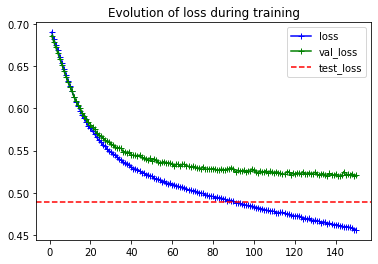

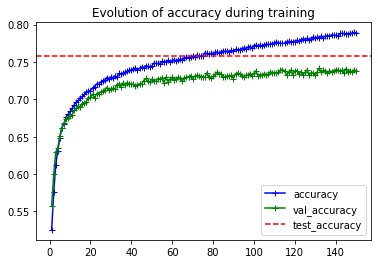

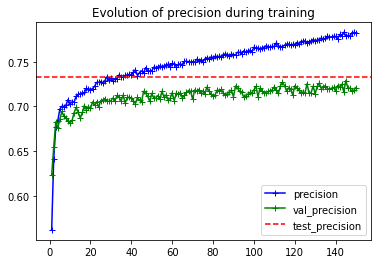

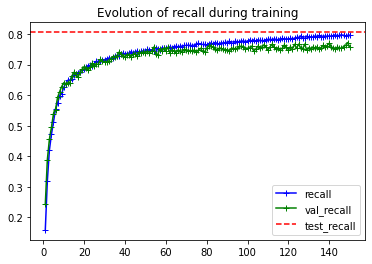

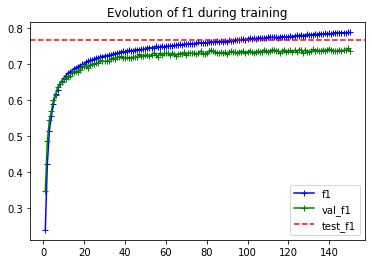

In [33]:
plot_perf(history, test_performance)

In [47]:
classes = (1., 0.)
dataiter = iter(test_loader)
text, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[int(labels[j])] for j in range(10)))

GroundTruth:    1.0   0.0   0.0   1.0   1.0   0.0   1.0   0.0   0.0   1.0


In [0]:
outputs = cnn(text)

In [49]:
#Predictions are energies from our two categories. Hence .5 < is 0.0 and < .5 is 1.0
print ("Predictions: ", end='   ')
for i in range(0,10):
  if(outputs[i] < .5):
    print(1.0, end='   ')
  else:
    print(0.0, end='   ')

Predictions:    0.0   0.0   1.0   0.0   1.0   1.0   1.0   1.0   0.0   1.0   

Model creidt to [EsterHlav](https://github.com/EsterHlav)'s GitHub [repo](https://github.com/EsterHlav/GloVe_Sentiment_Analysis_MLP_CNN_TwitterSentiment140
) 